In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lg
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [ ]:
df = pd.read_csv('train.csv')
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [ ]:
df.shape

(1460, 81)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<Axes: >

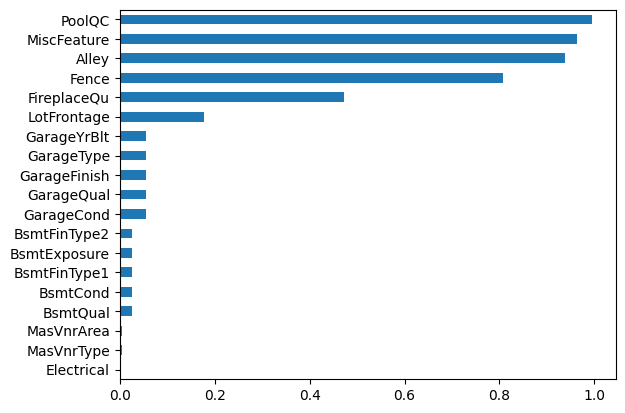

In [ ]:
feature_names = df.columns.tolist()
na_series = df[feature_names].isnull().sum()
missing_percent = na_series.apply(lambda x: x*1.0/df.shape[0])
missing_percent[missing_percent!=0.0].sort_values().plot.barh(x='Features', y='Percent')

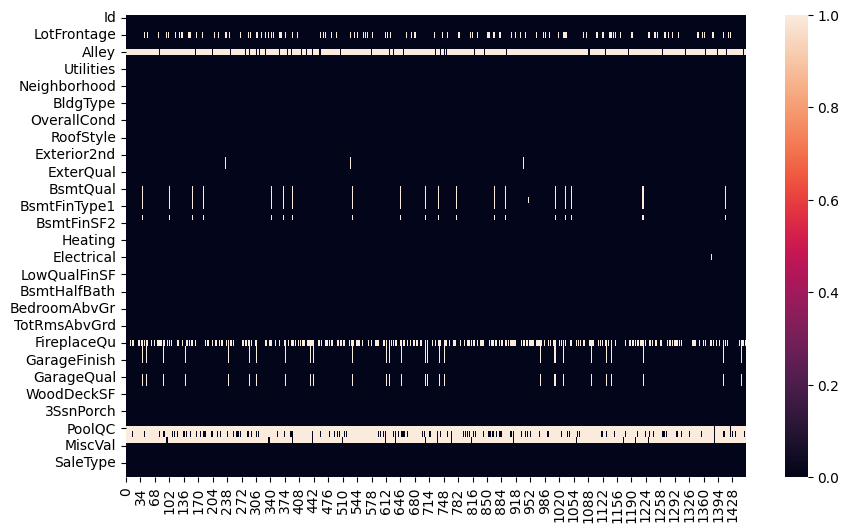

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose());

In [ ]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values(ascending=False,by="percent_missing")[:10]

,column_name,percent_missing
PoolQC,PoolQC,99.520548
MiscFeature,MiscFeature,96.301370
Alley,Alley,93.767123
Fence,Fence,80.753425
FireplaceQu,FireplaceQu,47.260274
LotFrontage,LotFrontage,17.739726
GarageYrBlt,GarageYrBlt,5.547945
GarageCond,GarageCond,5.547945
GarageType,GarageType,5.547945
GarageFinish,GarageFinish,5.547945


In [ ]:
df.drop(columns=["PoolQC","MiscFeature","Alley","Fence"],axis=1,inplace=True)

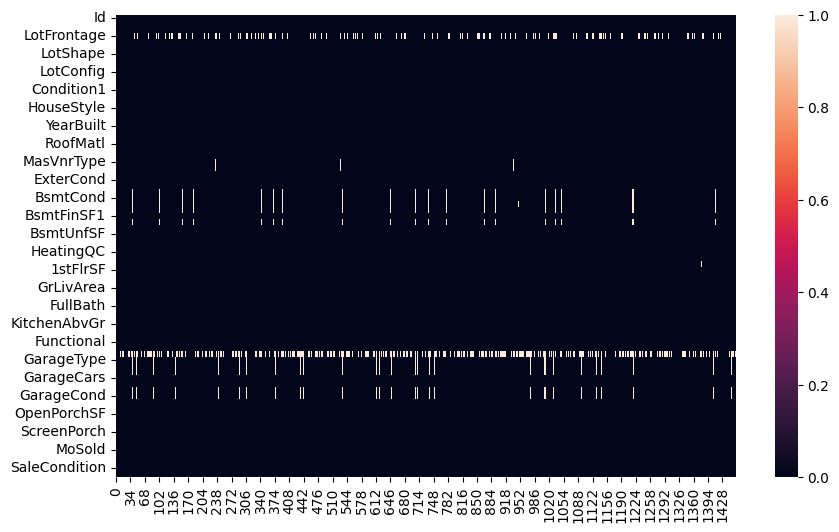

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose());

In [ ]:
num_cols =df.select_dtypes(include=np.number).columns
cat_cols = df.columns[df.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

We have 38 numeric columns: Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, SalePrice
And 39 categorical columns: MSZoning, Street, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, SaleType, SaleCondition


In [ ]:
binary_cols = cat_cols[df[cat_cols].nunique() == 2].tolist()
cat_cols = cat_cols.difference(binary_cols).tolist()

In [ ]:
display(binary_cols)

['Street', 'Utilities', 'CentralAir']

In [ ]:
missing_value_df.loc[binary_cols]

,column_name,percent_missing
Street,Street,0.0
Utilities,Utilities,0.0
CentralAir,CentralAir,0.0


In [ ]:
miss_cat=missing_value_df.loc[cat_cols][percent_missing!=0]
miss_cat

,column_name,percent_missing
BsmtCond,BsmtCond,2.534247
BsmtExposure,BsmtExposure,2.602740
BsmtFinType1,BsmtFinType1,2.534247
BsmtFinType2,BsmtFinType2,2.602740
BsmtQual,BsmtQual,2.534247
Electrical,Electrical,0.068493
FireplaceQu,FireplaceQu,47.260274
GarageCond,GarageCond,5.547945
GarageFinish,GarageFinish,5.547945
GarageQual,GarageQual,5.547945


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent',missing_values=np.nan)
df[miss_cat.index]=imputer.fit_transform(df[miss_cat.index])

In [ ]:
df[miss_cat.index].isna().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
Electrical      0
FireplaceQu     0
GarageCond      0
GarageFinish    0
GarageQual      0
GarageType      0
MasVnrType      0
dtype: int64

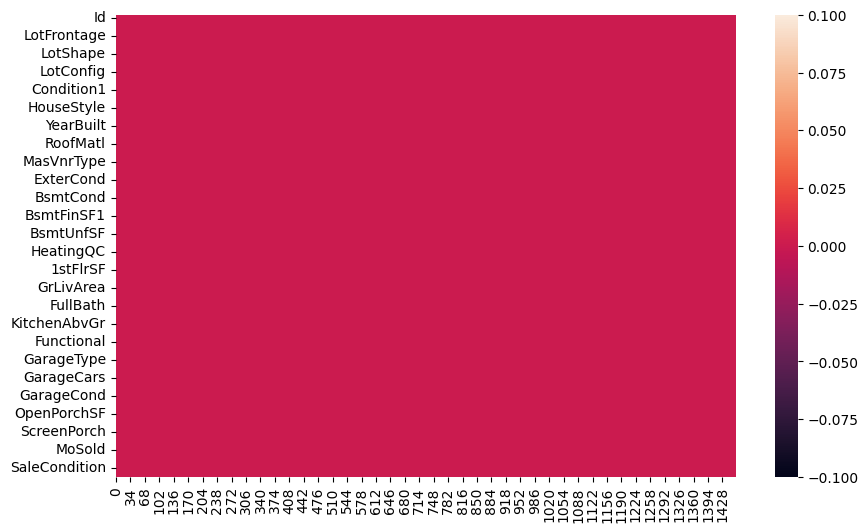

In [ ]:
imputer=KNNImputer(n_neighbors=5)
df[num_cols]=imputer.fit_transform(df[num_cols])

plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose());

nan values are complited

In [ ]:
df.describe().style.background_gradient()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.735890,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.907945,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1977.265616,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,23.334418,9981.264932,1.382997,1.112799,30.202904,20.645407,180.827336,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.719233,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1959.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.200000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
df.drop(columns='Id',axis=1,inplace=True)

In [ ]:
df.describe()[df.describe().index=='std'].iloc[0]<0.5

MSSubClass       False
LotFrontage      False
LotArea          False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
MasVnrArea       False
BsmtFinSF1       False
BsmtFinSF2       False
BsmtUnfSF        False
TotalBsmtSF      False
1stFlrSF         False
2ndFlrSF         False
LowQualFinSF     False
GrLivArea        False
BsmtFullBath     False
BsmtHalfBath      True
FullBath         False
HalfBath         False
BedroomAbvGr     False
KitchenAbvGr      True
TotRmsAbvGrd     False
Fireplaces       False
GarageYrBlt      False
GarageCars       False
GarageArea       False
WoodDeckSF       False
OpenPorchSF      False
EnclosedPorch    False
3SsnPorch        False
ScreenPorch      False
PoolArea         False
MiscVal          False
MoSold           False
YrSold           False
SalePrice        False
Name: std, dtype: bool

In [ ]:
df.drop(columns=["KitchenAbvGr","BsmtHalfBath"],axis=1,inplace=True)

In [ ]:
num_cols =df.select_dtypes(include=np.number).columns
cat_cols = df.columns[df.dtypes == 'object']


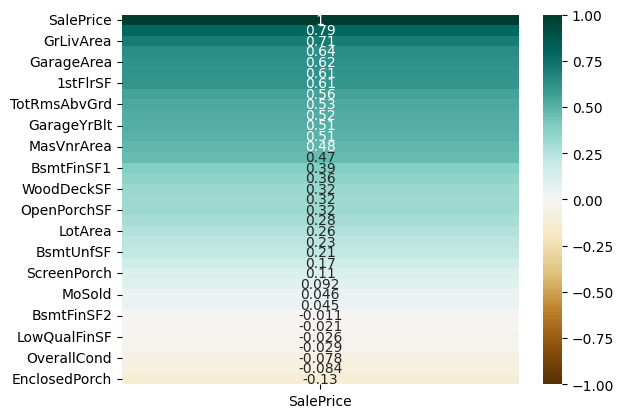

In [ ]:
heatmap = sns.heatmap(df[num_cols].corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

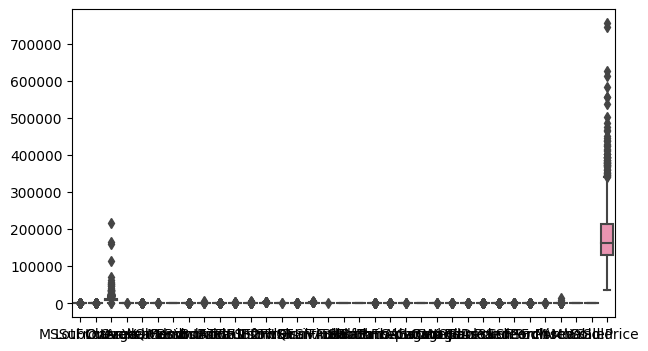

In [ ]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=df[num_cols])
plt.show()

In [ ]:
from scipy.stats import norm, skew

In [ ]:
import scipy.stats as stats
def diagnostic_plots(df, variable):
    plt.figure(figsize=(5,2))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

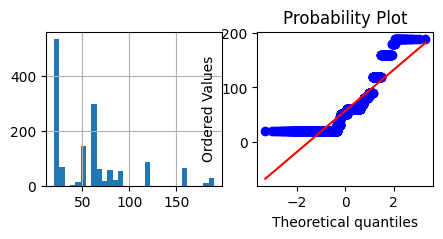

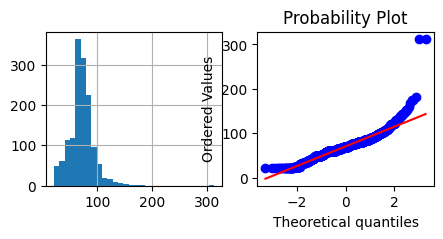

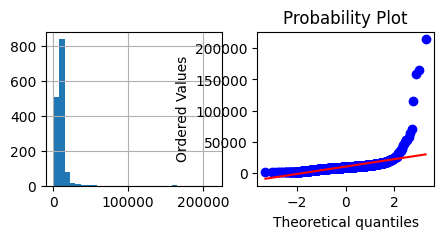

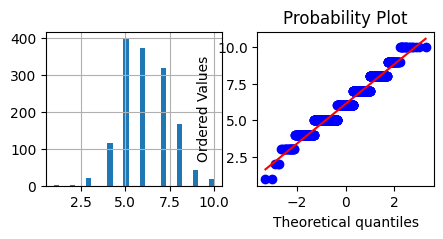

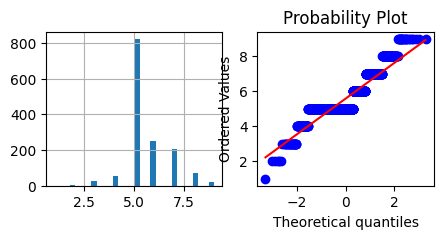

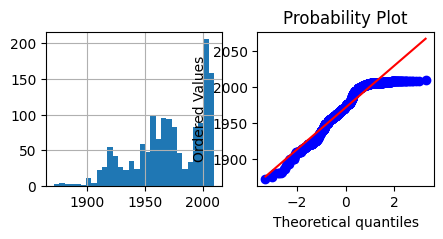

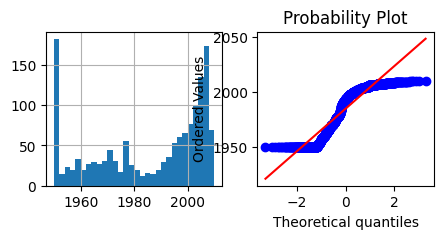

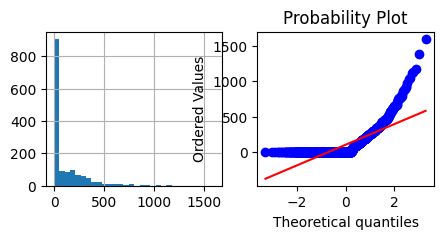

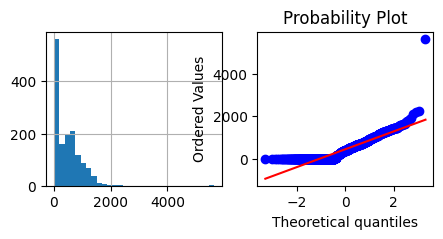

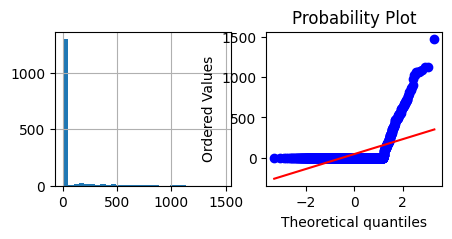

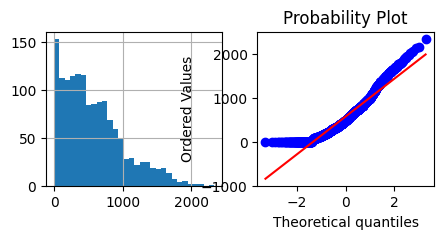

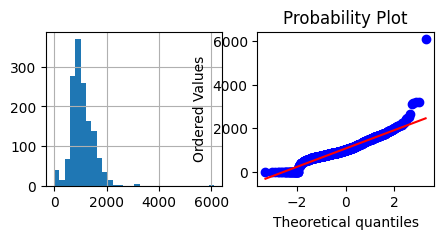

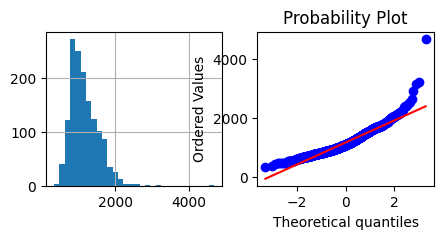

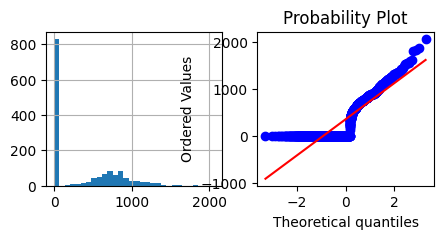

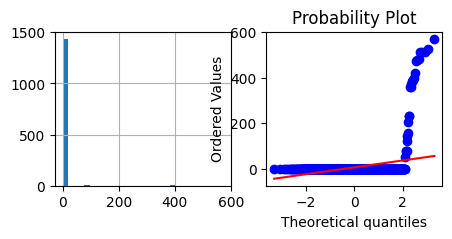

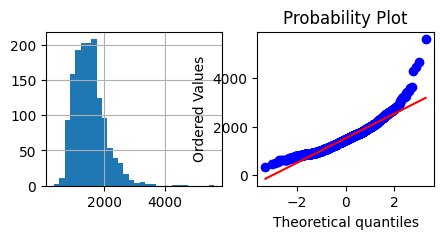

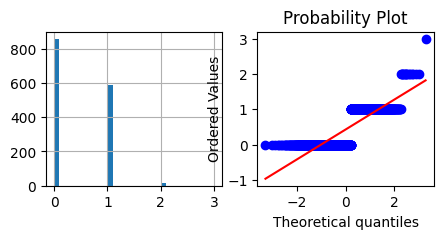

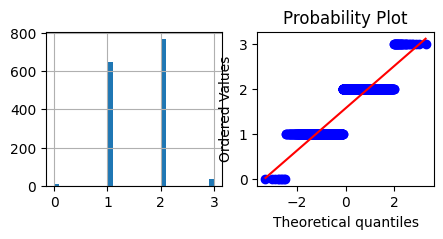

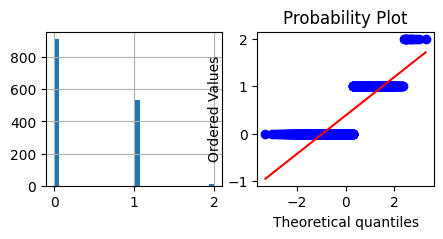

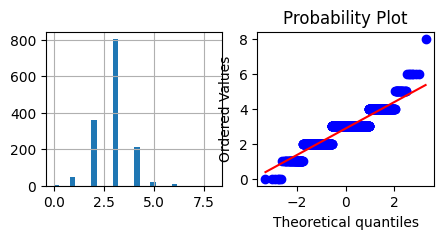

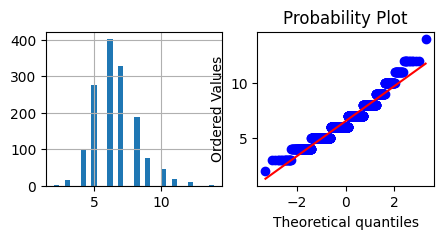

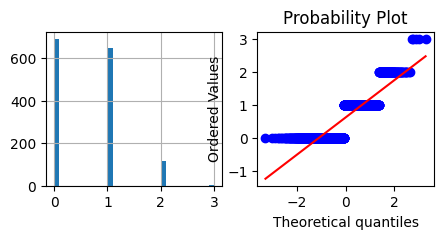

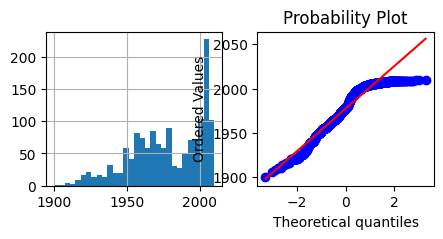

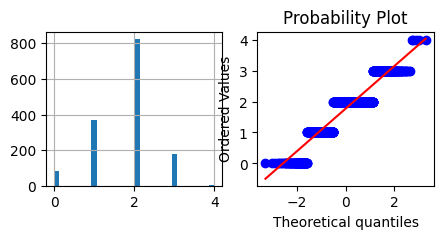

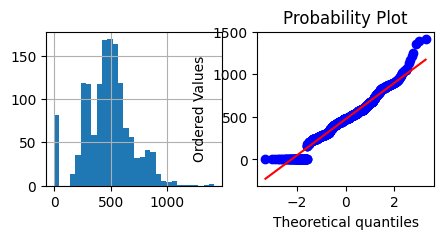

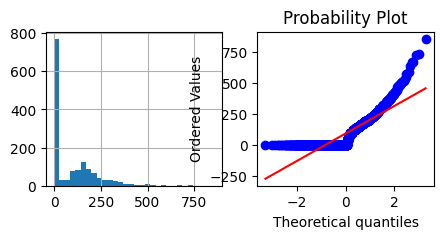

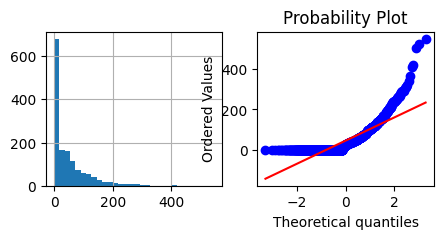

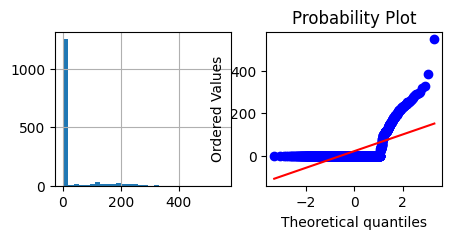

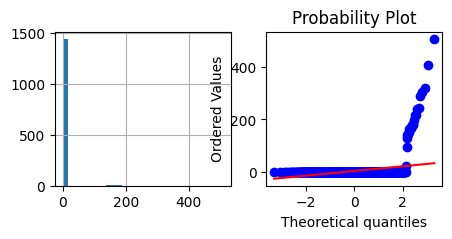

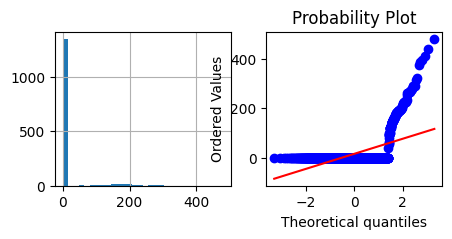

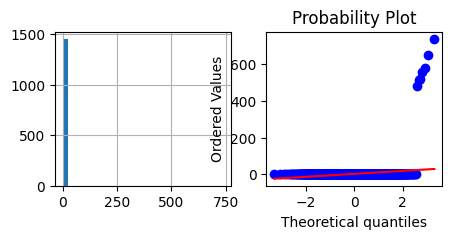

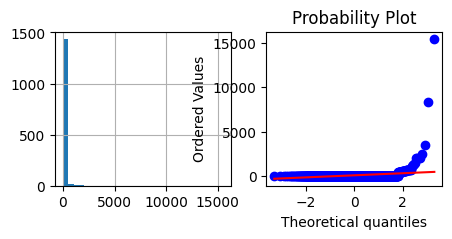

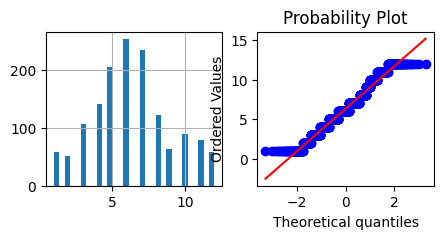

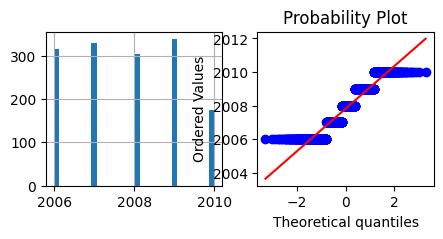

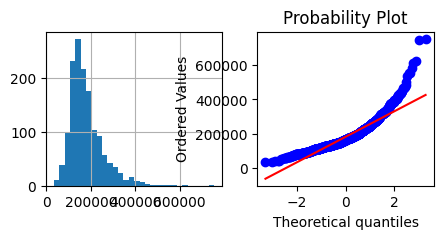

In [ ]:
for column in df[num_cols]:
  diagnostic_plots(df,column)


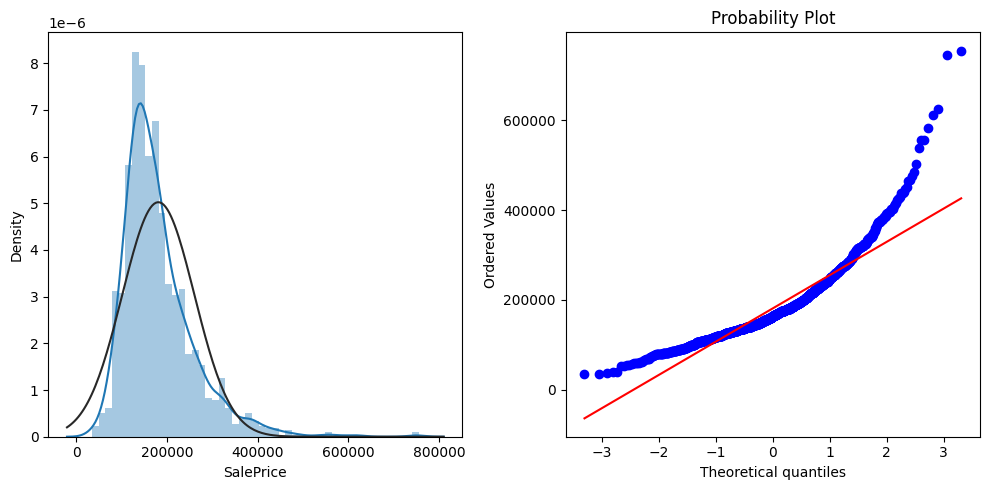

mu: 180921.196, sigma: 79415.292


In [ ]:

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.distplot(df['SalePrice'], fit = norm, ax = ax[0])
stats.probplot(df['SalePrice'], plot = plt)

plt.tight_layout()
plt.show()
mu, sigma = norm.fit(df['SalePrice'])
print("mu: {:.3f}, sigma: {:.3f}".format(mu, sigma))

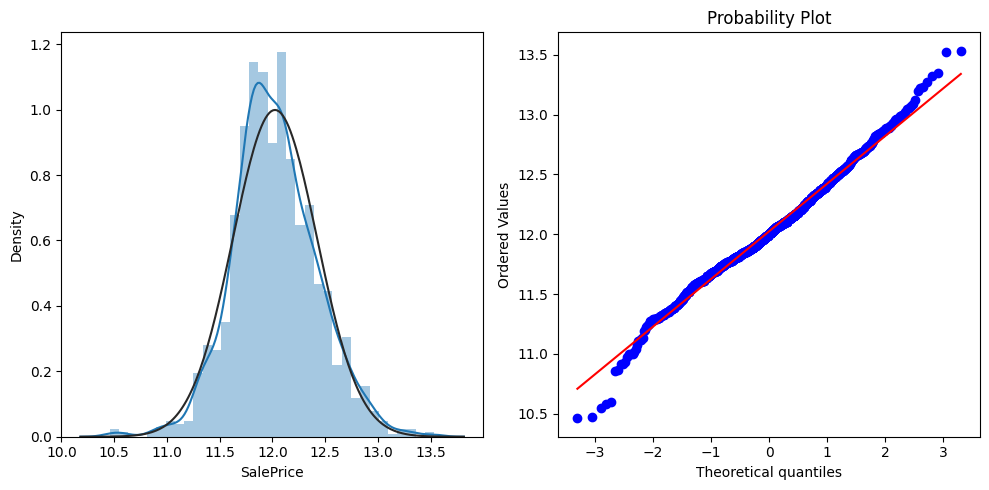

mu: 12.024, sigma: 0.399


In [ ]:
# apply log-transformation

df['SalePrice']= np.log1p(df['SalePrice'])

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.distplot(df['SalePrice'], fit = norm, ax = ax[0])
stats.probplot(df['SalePrice'], plot = plt)

plt.tight_layout()
plt.show()

mu, sigma = norm.fit(df['SalePrice'])
print("mu: {:.3f}, sigma: {:.3f}".format(mu, sigma))

In [ ]:
df.shape

(1460, 74)

In [ ]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
df.drop(columns=["RoofMatl","Electrical"],axis=1,inplace=True)

In [ ]:
X = df.drop('SalePrice', axis=1)
y = df["SalePrice"]

In [ ]:
num_cols =X.select_dtypes(include=np.number).columns
cat_cols = X.columns[X.dtypes == 'object']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numerical_transformer = Pipeline([('power', PowerTransformer()),
                                   ('scaler', StandardScaler())])

ct = ColumnTransformer([('num_transformer', numerical_transformer, num_cols),
                          ('encoder', OrdinalEncoder(), cat_cols)
                         ])
pipeline=Pipeline([('column_transformer', ct)])

In [ ]:
X_train = pipeline.fit_transform(X_train) # потом преобразуем  transform
X_test  = pipeline.transform(X_test) # для тестовых - просто transform

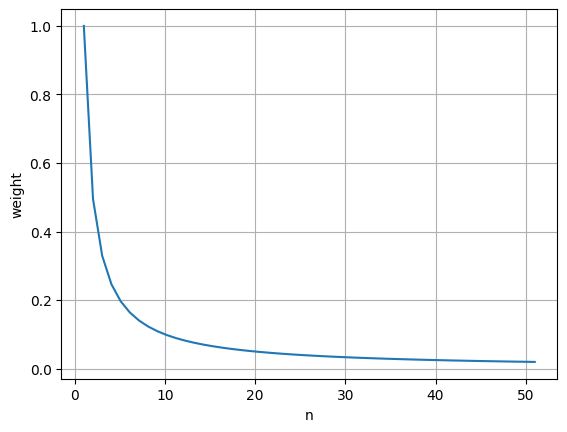

In [ ]:
x = np.linspace(1, 51, 50)
plt.plot(x, 1/x)
plt.xlabel('n')
plt.ylabel('weight')
plt.grid();

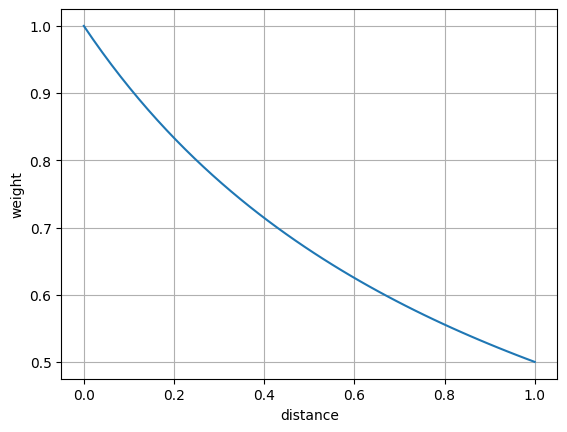

In [ ]:
a = 1
x = np.linspace(0, 1, 50)
plt.plot(x, 1 / (x + a))
plt.xlabel('distance')
plt.ylabel('weight')
plt.grid();

In [ ]:
def calc_weight_distance_2(dists):
    return 0.5 ** dists

In [ ]:
def calc_weight_n_neigbours(dists):
    weights = np.zeros(dists.shape)

    for i in range(dists.shape[1]):
        weights[:, i] = 1/(i+1)

    return weights

In [ ]:
from sklearn.model_selection import GridSearchCV # для поиска по сетке гиперпараметров
from sklearn.neighbors import KNeighborsRegressor # Регрессия К-Ближайших соседей от scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import StratifiedKFold # при кросс-валидации разбиваем данные в пропорции целевой метки

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
parameters = {'n_neighbors':np.arange(1,30,4),
              'weights':['uniform', 'distance'],
              'metric':["minkowski",'euclidean','manhattan','chebyshev']}

n_iter_search = 20

kNN_search = RandomizedSearchCV(estimator = KNeighborsRegressor(),  # оптимизируем нашу модель
                                verbose = 3,  # чтобы он всё подробно расписал. если не интересно - пишем 0
                          param_distributions=parameters , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                          n_iter = n_iter_search # количество итераций
                          )

In [ ]:
y_train=np.array(y_train, dtype=np.float)

In [ ]:
kNN_search.fit(X_train, y_train)

kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.760 total time=   0.1s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.718 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.733 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.817 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.743 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=25, weights=uniform;, score=0.753 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=25, weights=uniform;, score=0.696 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=25, weights=uniform;, score=0.694 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=25, weights=uniform;, score=0.789 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=25, weights=uniform;, scor

In [ ]:
kNN_search.best_estimator_

KNeighborsRegressor(metric='manhattan', n_neighbors=21, weights='distance')

In [ ]:
from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

In [ ]:
y_predict=kNNbest.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.4f' % mse(y_test,y_predict))
print('RMSE: %.4f' % mse(y_test,y_predict,squared=False))

print('R2 : %.4f' %  r2_score(y_test,y_predict))

Ошибка на тестовых данных
MSE: 0.0362
RMSE: 0.1902
R2 : 0.8062


In [ ]:
DF_reg=pd.DataFrame(kNN_search.cv_results_)
DF = DF_reg[['param_n_neighbors','param_weights',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("purple", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_n_neighbors,param_weights,mean_test_score,std_test_score,rank_test_score
15,21,distance,0.790368,0.036549,1
11,13,uniform,0.782188,0.037972,2
2,5,uniform,0.778728,0.045136,3
4,9,distance,0.756097,0.041823,4
8,9,distance,0.756097,0.041823,4
0,13,distance,0.754627,0.034255,6
14,9,uniform,0.752913,0.042106,7
18,17,distance,0.750139,0.030878,8
13,21,distance,0.744042,0.033937,9
3,5,uniform,0.741858,0.042823,10


In [ ]:
model = KNeighborsRegressor(n_neighbors=13, weights=calc_weight_distance_2)
model.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=13,
                    weights=<function calc_weight_distance_2 at 0x7fa1447e4700>)

In [ ]:
y_predict=model.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.4f' % mse(y_test,y_predict))
print('RMSE: %.4f' % mse(y_test,y_predict,squared=False))

print('R2 : %.4f' %  r2_score(y_test,y_predict))

Ошибка на тестовых данных
MSE: 0.0375
RMSE: 0.1937
R2 : 0.7990


In [ ]:
model = KNeighborsRegressor(n_neighbors=13, weights=calc_weight_n_neigbours)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=13,
                    weights=<function calc_weight_n_neigbours at 0x7fa1447e4af0>)

In [ ]:
y_predict=model.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.4f' % mse(y_test,y_predict))
print('RMSE: %.4f' % mse(y_test,y_predict,squared=False))

print('R2 : %.4f' %  r2_score(y_test,y_predict))

Ошибка на тестовых данных
MSE: 0.0371
RMSE: 0.1926
R2 : 0.8012


- - outliers detection --- r2 score +

In [ ]:

def new_method(df,variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr

    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence

    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence

    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss


In [ ]:
X.shape

(1460, 71)

In [ ]:
X[num_cols][:2]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,2.0,1.0,3.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,2.0,0.0,3.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0


In [ ]:
for column in X[num_cols]:
  probable_outliers_tm, possible_outliers_tm = new_method(X, column)
  X[column][new_method(X,column)[0]]=np.nan


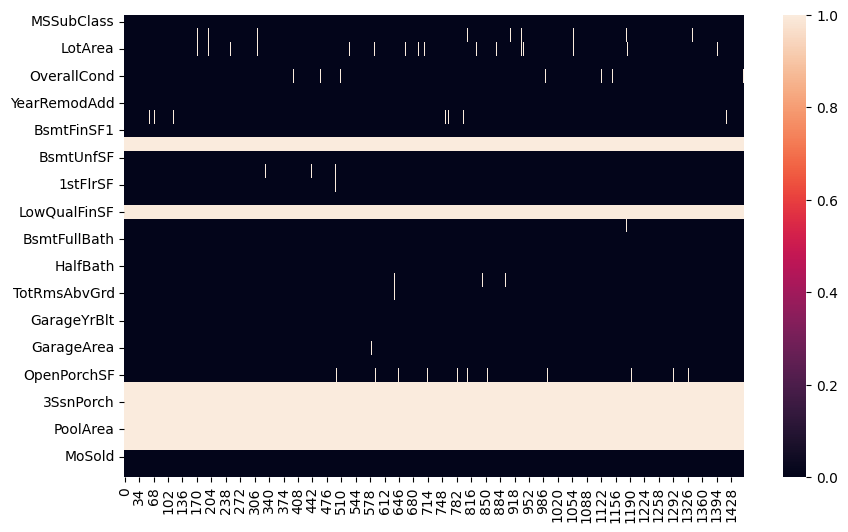

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(X[num_cols].isna().transpose());

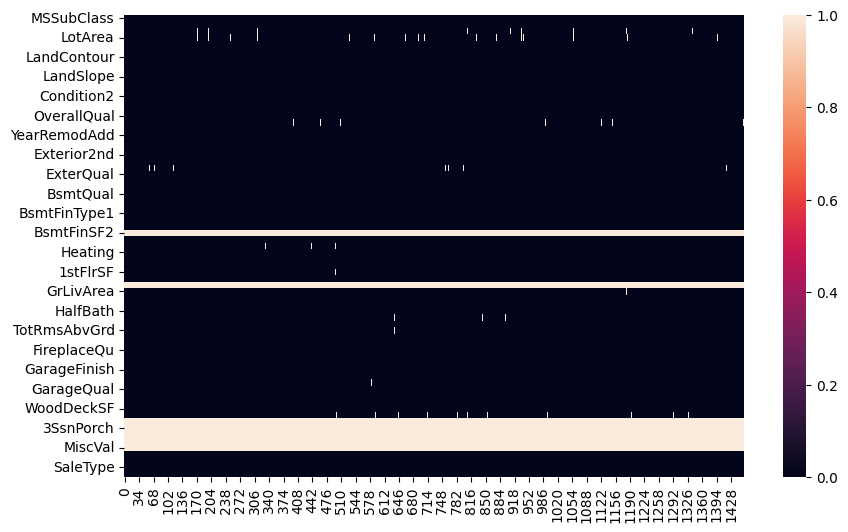

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(X.isna().transpose());

In [ ]:
X[num_cols].isna().sum()

MSSubClass          0
LotFrontage        15
LotArea            34
OverallQual         0
OverallCond        28
YearBuilt           0
YearRemodAdd        0
MasVnrArea         26
BsmtFinSF1          1
BsmtFinSF2       1460
BsmtUnfSF           0
TotalBsmtSF         5
1stFlrSF            3
2ndFlrSF            0
LowQualFinSF     1460
GrLivArea           4
BsmtFullBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        8
TotRmsAbvGrd        1
Fireplaces          0
GarageYrBlt         0
GarageCars          0
GarageArea          3
WoodDeckSF          3
OpenPorchSF        18
EnclosedPorch    1460
3SsnPorch        1460
ScreenPorch      1460
PoolArea         1460
MiscVal          1460
MoSold              0
YrSold              0
dtype: int64

In [ ]:
X.drop(columns=['MiscVal','PoolArea','ScreenPorch','3SsnPorch','EnclosedPorch','LowQualFinSF','BsmtFinSF2'],axis=1,inplace=True)

In [ ]:
X.shape

(1460, 64)

In [ ]:
num_cols =X.select_dtypes(include=np.number).columns
cat_cols = X.columns[X.dtypes == 'object']

In [ ]:
imputer=KNNImputer(n_neighbors=5)
X[num_cols]=imputer.fit_transform(X[num_cols])

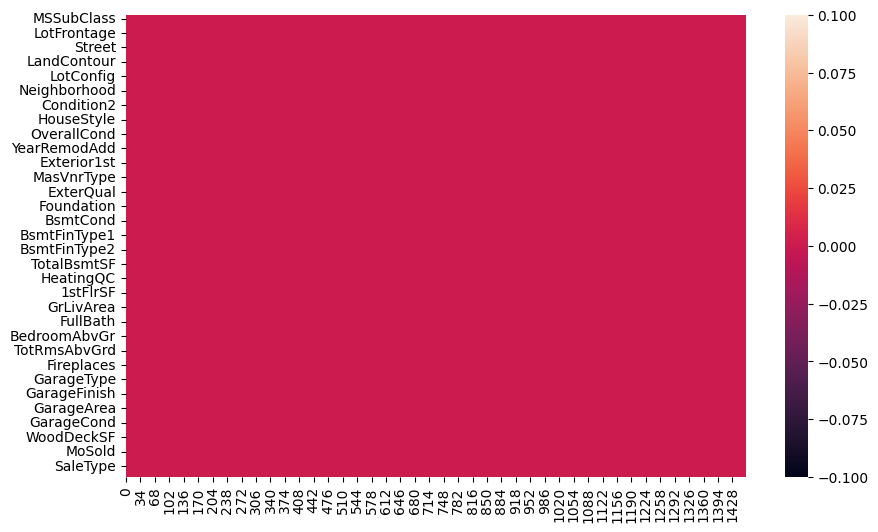

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(X.isna().transpose());

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape,X_test.shape

((1168, 64), (292, 64))

In [ ]:
y_train.shape, y_test.shape

((1168,), (292,))

In [ ]:

cat_pipe_ordinal = Pipeline([
    ('encoder', OrdinalEncoder( ))
])
numerical_pipe = Pipeline([
    ('power', PowerTransformer()),
    ('scaler', StandardScaler())
])
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_cols),
    ('cat', cat_pipe_ordinal, cat_cols)
])

pipe_ordinal = Pipeline([
    ('preprocessors', preprocessors)
])

In [ ]:
X_train = pipe_ordinal.fit_transform(X_train) # потом преобразуем  transform
X_test  = pipe_ordinal.transform(X_test) # для тестовых - просто transform

add our new_function to weights

In [ ]:
parameters = {'n_neighbors':np.arange(1,30,4),
              'weights':['uniform', 'distance',calc_weight_n_neigbours],
              'metric':["minkowski",'euclidean','manhattan','chebyshev']}

n_iter_search = 20

kNN_search = RandomizedSearchCV(estimator = KNeighborsRegressor(),  # оптимизируем нашу модель
                                verbose = 3,  # чтобы он всё подробно расписал. если не интересно - пишем 0
                          param_distributions=parameters , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                          n_iter = n_iter_search # количество итераций
                          )

In [ ]:
kNN_search.fit(X_train, y_train)

kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=manhattan, n_neighbors=25, weights=<function calc_weight_n_neigbours at 0x7fa1447e4af0>;, score=0.815 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=25, weights=<function calc_weight_n_neigbours at 0x7fa1447e4af0>;, score=0.762 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=25, weights=<function calc_weight_n_neigbours at 0x7fa1447e4af0>;, score=0.791 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=25, weights=<function calc_weight_n_neigbours at 0x7fa1447e4af0>;, score=0.868 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=25, weights=<function calc_weight_n_neigbours at 0x7fa1447e4af0>;, score=0.827 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=29, weights=uniform;, score=0.765 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=29, weights=uniform;, score=0.761 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbor

In [ ]:
kNN_search.best_estimator_

KNeighborsRegressor(metric='manhattan', n_neighbors=25,
                    weights=<function calc_weight_n_neigbours at 0x7fa1447e4af0>)

In [ ]:
y_predict=kNNbest.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.4f' % mse(y_test,y_predict))
print('RMSE: %.4f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))

Ошибка на тестовых данных
MSE: 0.0314
RMSE: 0.1772
R2 : 0.8318


In [ ]:
DF_reg=pd.DataFrame(kNN_search.cv_results_)
DF = DF_reg[['param_n_neighbors','param_weights',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("purple", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_n_neighbors,param_weights,mean_test_score,std_test_score,rank_test_score
0,25,,0.812780,0.035505,1
8,9,,0.810050,0.037562,2
15,5,,0.799926,0.040065,3
5,25,distance,0.795286,0.030006,4
1,29,uniform,0.787007,0.032783,5
17,29,,0.778505,0.028984,6
6,29,,0.778505,0.028984,6
13,9,,0.777709,0.030655,8
12,17,distance,0.766882,0.027594,9
2,17,uniform,0.761170,0.027816,10


In [ ]:
model = KNeighborsRegressor(n_neighbors=13, weights=calc_weight_distance_2,metric="manhattan")
model.fit(X_train, y_train)
y_predict=model.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.4f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))

Ошибка на тестовых данных
MSE: 0.0347
RMSE: 0.2
R2 : 0.8140


In [ ]:
df = pd.read_csv('train.csv')
y=df["SalePrice"]

In [ ]:
X["Id"]=df.Id

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_test_=X_test.copy()

In [ ]:
X_train.drop("Id",axis=1,inplace=True)
X_test.drop("Id",axis=1,inplace=True)
print(" ")

In [ ]:
X_train = pipe_ordinal.fit_transform(X_train) # потом преобразуем  transform
X_test  = pipe_ordinal.transform(X_test) # для тестовых - просто transform

In [ ]:
parameters = {'n_neighbors':np.arange(1,30,4),
              'weights':['uniform', 'distance'],
              'metric':["minkowski",'euclidean','manhattan','chebyshev']}

n_iter_search = 20

kNN_search = RandomizedSearchCV(estimator = KNeighborsRegressor(),  # оптимизируем нашу модель
                                verbose = 3,  # чтобы он всё подробно расписал. если не интересно - пишем 0
                          param_distributions=parameters , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                          n_iter = n_iter_search # количество итераций
                          )

In [ ]:
kNN_search.fit(X_train, y_train)

kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=chebyshev, n_neighbors=21, weights=distance;, score=0.431 total time=   0.0s
[CV 2/5] END metric=chebyshev, n_neighbors=21, weights=distance;, score=0.229 total time=   0.0s
[CV 3/5] END metric=chebyshev, n_neighbors=21, weights=distance;, score=0.181 total time=   0.0s
[CV 4/5] END metric=chebyshev, n_neighbors=21, weights=distance;, score=0.272 total time=   0.0s
[CV 5/5] END metric=chebyshev, n_neighbors=21, weights=distance;, score=0.237 total time=   0.0s
[CV 1/5] END metric=chebyshev, n_neighbors=5, weights=distance;, score=0.439 total time=   0.0s
[CV 2/5] END metric=chebyshev, n_neighbors=5, weights=distance;, score=0.295 total time=   0.0s
[CV 3/5] END metric=chebyshev, n_neighbors=5, weights=distance;, score=0.277 total time=   0.0s
[CV 4/5] END metric=chebyshev, n_neighbors=5, weights=distance;, score=0.338 total time=   0.0s
[CV 5/5] END metric=chebyshev, n_neighbors=5, weights=distance;, scor

In [ ]:
kNN_search.best_estimator_

KNeighborsRegressor(metric='manhattan', n_neighbors=9, weights='distance')

In [ ]:
y_predict=kNNbest.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.4f' % mse(y_test,y_predict))
print('RMSE: %.4f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))

Ошибка на тестовых данных
MSE: 1329809430.0165
RMSE: 36466.5522
R2 : 0.8266


In [ ]:
my_submission = pd.DataFrame({'Id': X_test_.Id, 'SalePrice': y_predict}).set_index("Id")
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

display(my_submission)

,SalePrice
Id,
893,130079.771816
1106,307174.885542
414,105422.722618
523,151114.403473
1037,324401.483520
...,...
480,110302.115066
1362,291683.154167
803,203989.549927


<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
RMSE:  36466.55220906505
Variance score: 0.83


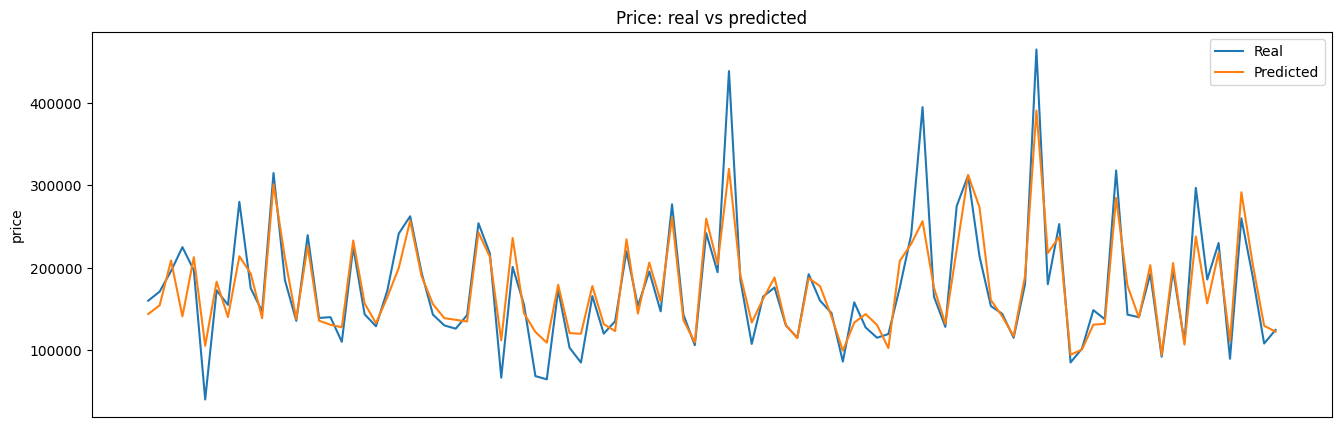

In [ ]:
predicted = y_predict

A = np.array(y_test).reshape(-1, 1)
B = predicted.reshape(-1, 1)
print(type(predicted))
print(type(y_test))
plt.rcParams['figure.figsize'] = 16,5
plt.figure()
plt.plot(A[-100:], label="Real")
plt.plot(B[-100:], label="Predicted")
plt.legend()
plt.title("Price: real vs predicted")
plt.ylabel("price")
plt.xticks(())
rmse = np.sqrt(mean_squared_error(y_test, predicted))

print('RMSE: ',rmse)

print('Variance score: %.2f' % r2_score(y_test, predicted))
plt.show()

analize test df

In [ ]:
test = pd.read_csv('test.csv')

<Axes: >

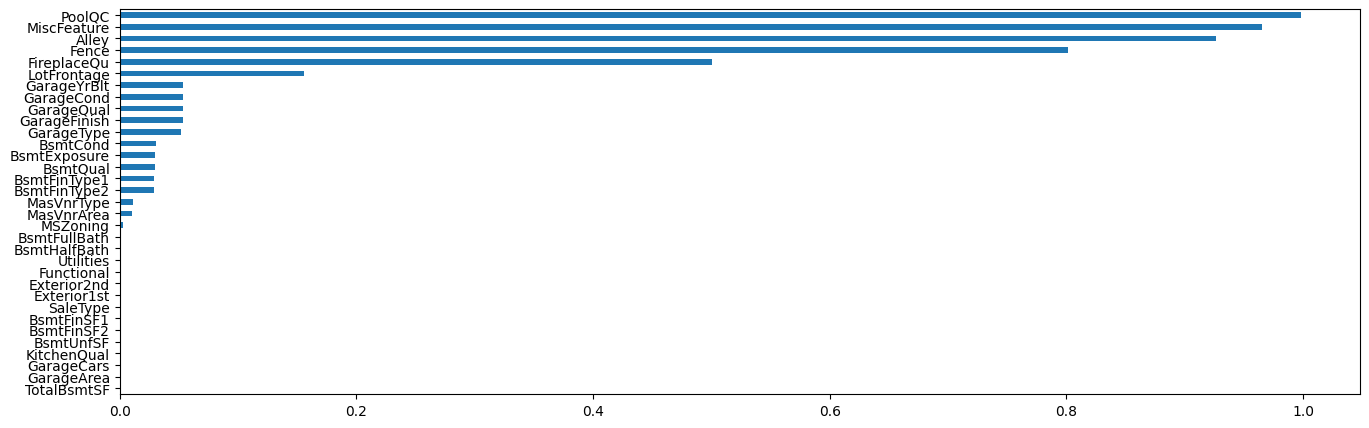

In [ ]:
feature_names = test.columns.tolist()
na_series = test[feature_names].isnull().sum()
missing_percent = na_series.apply(lambda x: x*1.0/test.shape[0])
missing_percent[missing_percent!=0.0].sort_values().plot.barh(x='Features', y='Percent')

In [ ]:
test_Ids = test.Id
test = test.drop('Id', axis = 1)

In [ ]:
percent_missing = test.isnull().sum() * 100 / len(test)
missing_value_df = pd.DataFrame({'column_name': test.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values(ascending=False,by="percent_missing")[:10]

,column_name,percent_missing
PoolQC,PoolQC,99.794380
MiscFeature,MiscFeature,96.504455
Alley,Alley,92.666210
Fence,Fence,80.123372
FireplaceQu,FireplaceQu,50.034270
LotFrontage,LotFrontage,15.558602
GarageYrBlt,GarageYrBlt,5.346127
GarageFinish,GarageFinish,5.346127
GarageQual,GarageQual,5.346127
GarageCond,GarageCond,5.346127


In [ ]:
test.drop(columns=["PoolQC","MiscFeature","Alley","Fence"],axis=1,inplace=True)

In [ ]:
num_cols =test.select_dtypes(include=np.number).columns
cat_cols = test.columns[test.dtypes == 'object']

In [ ]:
miss_cat=missing_value_df.loc[cat_cols][percent_missing!=0]
miss_cat

,column_name,percent_missing
MSZoning,MSZoning,0.274160
Utilities,Utilities,0.137080
Exterior1st,Exterior1st,0.068540
Exterior2nd,Exterior2nd,0.068540
MasVnrType,MasVnrType,1.096642
BsmtQual,BsmtQual,3.015764
BsmtCond,BsmtCond,3.084304
BsmtExposure,BsmtExposure,3.015764
BsmtFinType1,BsmtFinType1,2.878684
BsmtFinType2,BsmtFinType2,2.878684


In [ ]:
imputer = SimpleImputer(strategy='most_frequent',missing_values=np.nan)
test[miss_cat.index]=imputer.fit_transform(test[miss_cat.index])

In [ ]:
imputer=KNNImputer(n_neighbors=5)
test[num_cols]=imputer.fit_transform(test[num_cols])

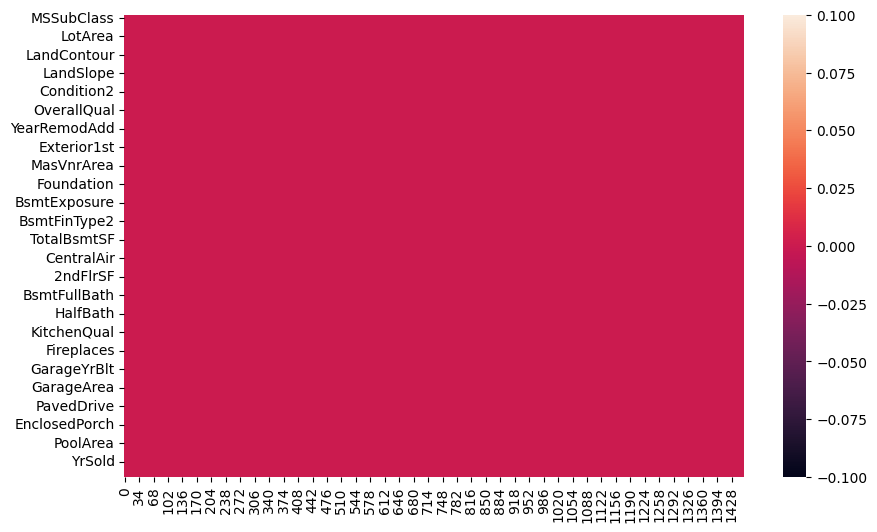

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(test.isna().transpose());

In [ ]:
test.drop(columns=["KitchenAbvGr","BsmtHalfBath"],axis=1,inplace=True)

In [ ]:
num_cols =test.select_dtypes(include=np.number).columns
cat_cols = test.columns[test.dtypes == 'object']


In [ ]:
test.drop(columns=["RoofMatl","Electrical"],axis=1,inplace=True)

In [ ]:
num_cols =test.select_dtypes(include=np.number).columns
cat_cols = test.columns[test.dtypes == 'object']

In [ ]:
test.drop(columns=['MiscVal','PoolArea','ScreenPorch','3SsnPorch','EnclosedPorch','LowQualFinSF','BsmtFinSF2'],axis=1,inplace=True)

In [ ]:
num_cols =test.select_dtypes(include=np.number).columns
cat_cols = test.columns[test.dtypes == 'object']

In [ ]:
imputer=KNNImputer(n_neighbors=5)
test[num_cols]=imputer.fit_transform(test[num_cols])

In [ ]:
test  = pipe_ordinal.transform(test)

In [ ]:
y_predict=kNNbest.predict(test)

In [ ]:
my_submission = pd.DataFrame({'Id': test_Ids, 'SalePrice': y_predict})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

display(my_submission)

,Id,SalePrice
0,1461,127787.246863
1,1462,152037.827124
2,1463,189793.255410
3,1464,200263.862509
4,1465,211697.241296
...,...,...
1454,2915,93925.582218
1455,2916,94953.324079
1456,2917,140990.563709
1457,2918,130561.375390
